# Импортируем необходимые библиотеки

In [5]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

!pip install import_ipynb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pandas numpy catboost xgboost lightgbm optuna matplotlib seaborn

In [6]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
import lightgbm as lgb

import optuna

import warnings
warnings.filterwarnings('ignore')

# Загрузим данные

In [10]:
ROOT_DIR = 'mlcourse-dota2-win-prediction'

train_features = pd.read_csv(os.path.join(ROOT_DIR, 'train_features.csv'), index_col='match_id_hash')
train_targets = pd.read_csv(os.path.join(ROOT_DIR, 'train_targets.csv'), index_col='match_id_hash')

In [11]:
train_features.head(2)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.0,0,0,0,0,0.0,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.0,0,0,0,0,0.0,0,0,0,0


In [12]:
train_targets.head(2)

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,False,992,837,NaN
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN


In [13]:
X = train_features
y = train_targets['radiant_win']

# EDA (5 баллов)

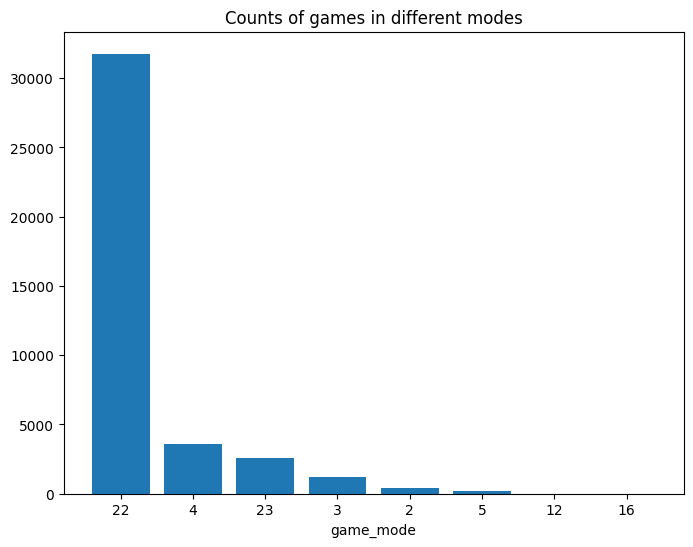

In [14]:
mode_counts = X['game_mode'].value_counts()
mode_counts = mode_counts.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
plt.bar(mode_counts.index.astype(str), mode_counts.values)
plt.title("Counts of games in different modes")
plt.xlabel("game_mode")
plt.show()

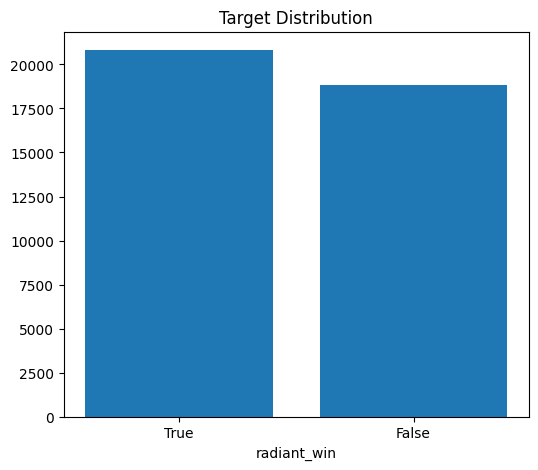

In [15]:
win_counts = y.value_counts()
win_counts = win_counts.sort_values(ascending=False)

plt.figure(figsize=(6, 5))
plt.bar(win_counts.index.astype(str), win_counts.values)
plt.title("Target Distribution")
plt.xlabel("radiant_win")
plt.show()

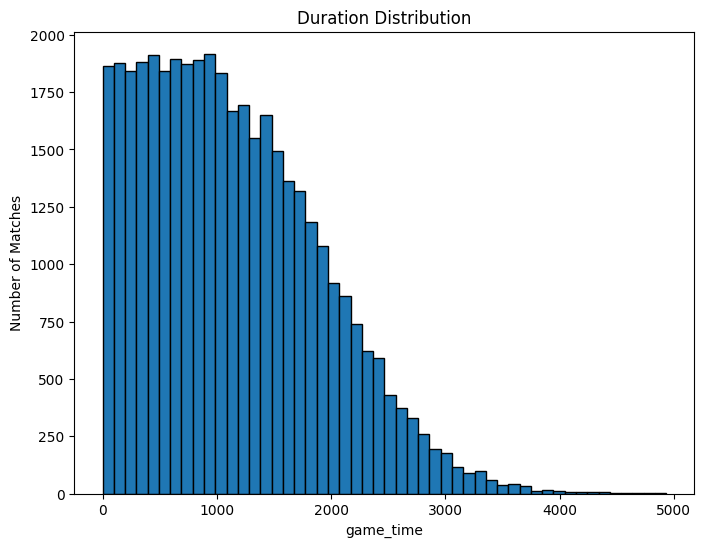

In [16]:
# Duration Distribution (Распределение длительности матчей)
durations = X['game_time']

plt.figure(figsize=(8, 6))
plt.hist(durations, bins=50, edgecolor='black')
plt.title("Duration Distribution")
plt.xlabel("game_time")
plt.ylabel("Number of Matches")
plt.show()

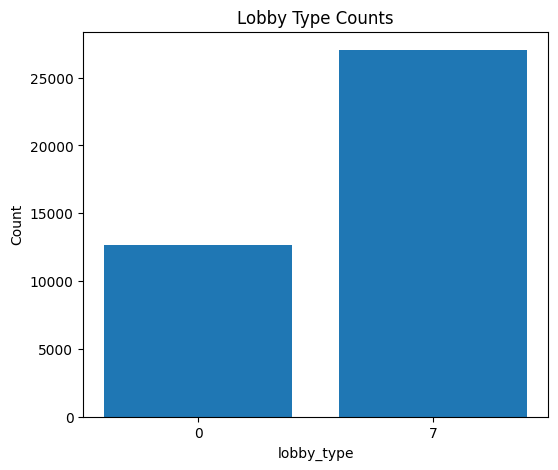

In [17]:
# Lobby Type Counts (Распределение матчей по типу лобби)
lobby_counts = X['lobby_type'].value_counts().sort_index()

plt.figure(figsize=(6, 5))
plt.bar(lobby_counts.index.astype(str), lobby_counts.values)
plt.title("Lobby Type Counts")
plt.xlabel("lobby_type")
plt.ylabel("Count")
plt.show()

# Обучим CatBoost на чистых данных и посмотрим на метрики

In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = CatBoostClassifier(
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall CAT OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8187, Accuracy score: 0.7287
FOLD 1, Validation ROC-AUC score: 0.8029, Accuracy score: 0.7117
FOLD 2, Validation ROC-AUC score: 0.8007, Accuracy score: 0.7157
FOLD 3, Validation ROC-AUC score: 0.8047, Accuracy score: 0.7176
FOLD 4, Validation ROC-AUC score: 0.8060, Accuracy score: 0.7146

Overall CAT OOF ROC-AUC: 0.8066, OOF Accuracy: 0.7176


# Генерация фичей (5 баллов)

Генерация фичей является одной из важнейших частей построения пайплайна машинного обучения. В данной части вам предлагается придумать и сгенерировать полезные фичи для модели. Важно: они должны повысить метрику. В качестве примера сгенерированы статистические фичи. Вы можете не использовать их, если не считаете их нужными.

In [19]:
def fe(data):
    df = data.copy()
    players = [1, 2, 3, 4, 5]

    eps = 1e-8 # избегаем деления на 0

    team_stats = {
        'kills': 'kills',
        'deaths': 'deaths',
        'assists': 'assists',
        'denies': 'denies',
        'lh': 'lh',
        'gold': 'gold',
        'xp': 'xp',
        'tower_kills': 'towers_killed',
        'roshan_kills': 'roshans_killed',
        'obs_placed': 'obs_placed',
        'sen_placed': 'sen_placed',
        'teamfight_participation': 'teamfight_participation',
        'firstblood': 'firstblood_claimed'
    }
    for team_prefix in ['r', 'd']:
        for stat_name, col_suffix in team_stats.items():
            cols = [f"{team_prefix}{i}_{col_suffix}" for i in players]
            if col_suffix == 'firstblood_claimed':
                df[f"{team_prefix}_total_firstblood"] = df[cols].sum(axis=1)
            else:
                df[f"{team_prefix}_total_{stat_name}"] = df[cols].sum(axis=1)

    stats_for_mean_std = ['kills', 'deaths', 'assists', 'gold', 'xp', 'denies', 'lh']
    for team_prefix in ['r', 'd']:
        for stat in stats_for_mean_std:
            cols = [f"{team_prefix}{i}_{stat}" for i in players]
            df[f"{team_prefix}_mean_{stat}"] = df[cols].mean(axis=1)
            df[f"{team_prefix}_std_{stat}"] = df[cols].std(axis=1)

    for team_prefix in ['r', 'd']:
        gold_cols = [f"{team_prefix}{i}_gold" for i in players]
        xp_cols   = [f"{team_prefix}{i}_xp" for i in players]
        df[f"{team_prefix}_total_net_worth"] = df[gold_cols].sum(axis=1) + df[xp_cols].sum(axis=1)
        df[f"{team_prefix}_mean_net_worth"] = (df[gold_cols].add(df[xp_cols]).mean(axis=1))

    for team_prefix in ['r', 'd']:
        impact_vals = [(df[f"{team_prefix}{i}_kills"] + df[f"{team_prefix}{i}_assists"] - df[f"{team_prefix}{i}_deaths"])
                       for i in players]
        df[f"{team_prefix}_total_impact"] = sum(impact_vals)

    diff_stats = ['kills', 'deaths', 'assists', 'denies', 'lh', 'gold', 'xp',
                  'tower_kills', 'roshan_kills', 'obs_placed', 'sen_placed',
                  'teamfight_participation', 'firstblood', 'impact']
    for stat in diff_stats:
        r_col = f"r_total_{stat}"
        d_col = f"d_total_{stat}"
        if r_col in df.columns and d_col in df.columns:
            df[f"{stat}_diff"] = df[r_col] - df[d_col]

    df['net_worth_diff'] = df['r_total_net_worth'] - df['d_total_net_worth']

    df['total_kills_ratio'] = df['r_total_kills'] / (df['d_total_kills'] + eps)
    df['gold_ratio']        = df['r_total_gold']  / (df['d_total_gold']  + eps)
    df['xp_ratio']          = df['r_total_xp']    / (df['d_total_xp']    + eps)

    def team_avg_distance(row, team_prefix):
        coords = [(row[f"{team_prefix}{i}_x"], row[f"{team_prefix}{i}_y"]) for i in players]
        dist_sum = 0.0
        count = 0
        for i in range(len(coords)):
            x1, y1 = coords[i]
            for j in range(i+1, len(coords)):
                x2, y2 = coords[j]
                dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
                dist_sum += dist
                count += 1
        return dist_sum / count if count > 0 else 0.0

    df['r_avg_distance'] = df.apply(lambda row: team_avg_distance(row, 'r'), axis=1)
    df['d_avg_distance'] = df.apply(lambda row: team_avg_distance(row, 'd'), axis=1)

    return df

# Теперь обучим CatBoost на данных с новыми фичами и посмотрим на метрики

In [20]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train)
    X_valid = fe(X_valid)

    model = CatBoostClassifier(
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8361, Accuracy score: 0.7448
FOLD 1, Validation ROC-AUC score: 0.8161, Accuracy score: 0.7248
FOLD 2, Validation ROC-AUC score: 0.8186, Accuracy score: 0.7314
FOLD 3, Validation ROC-AUC score: 0.8200, Accuracy score: 0.7362
FOLD 4, Validation ROC-AUC score: 0.8250, Accuracy score: 0.7381

Overall OOF ROC-AUC: 0.8230, OOF Accuracy: 0.7351


# Обработка категориальных фичей средствами CatBoost

Попробуем подать категориальные фичи в модель через cat_features.

In [ ]:
# выделим очевидные категориальные фичи - вы можете попробовать выделить больше / сгенерировать новые или же вовсе отказаться от этой идеи

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train)
    X_valid = fe(X_valid)

    model = CatBoostClassifier(
        cat_features=cats,
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall CAT w/ FE OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8348, Accuracy score: 0.7464
FOLD 1, Validation ROC-AUC score: 0.8170, Accuracy score: 0.7273
FOLD 2, Validation ROC-AUC score: 0.8171, Accuracy score: 0.7272
FOLD 3, Validation ROC-AUC score: 0.8194, Accuracy score: 0.7296
FOLD 4, Validation ROC-AUC score: 0.8248, Accuracy score: 0.7343

Overall CAT w/ FE OOF ROC-AUC: 0.8225, OOF Accuracy: 0.7330


# Отбор фичей (5 баллов)

Возможно, на этапе генерации фичей вы решили прибегнуть к автоматической генерации (если нет, то советую обратить внимание на библиотеку OpenFE), или же просто генерировали все подряд. Также, возможно, исходные данные содержали бесполезные и шумные фичи.

Вам предлагается исследовать это и оставить только те фичи, которые вы считаете важными.

Идеи для отбора фичей:
- по feature importance
- по permutation importance
- по shap values
- recursive feature elimination
- sequential feature selection

Также обратите внимание на гайд от catboost: https://github.com/catboost/catboost/blob/master/catboost/tutorials/feature_selection/select_features_tutorial.ipynb

In [21]:
# бейзлайн: используем встроенные инструменты catboost - вы можете работать с ним или обратиться к другим инструментам
# здесь нужно быть аккуратным, ведь удаление фичей всегда может привести к падению скора
# необходимо подобрать грамотный подход, а это можно сделать только путем экспериментов

from sklearn.model_selection import train_test_split

model = CatBoostClassifier(
    random_state=69,
    verbose=0,
    thread_count=4
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

X_train = fe(X_train)
X_test = fe(X_test)

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select=list(range(X_train.shape[1])),
    num_features_to_select=50,
    algorithm='RecursiveByLossFunctionChange',
    shap_calc_type='Regular',
    train_final_model=False,
    verbose=1,
    plot=False
)

selected_features = summary['selected_features']


Learning rate set to 0.073263
Step #1 out of 1
0:	learn: 0.6693715	test: 0.6688454	best: 0.6688454 (0)	total: 99.5ms	remaining: 1m 39s
1:	learn: 0.6471968	test: 0.6465260	best: 0.6465260 (1)	total: 183ms	remaining: 1m 31s
2:	learn: 0.6285845	test: 0.6277429	best: 0.6277429 (2)	total: 263ms	remaining: 1m 27s
3:	learn: 0.6131775	test: 0.6118963	best: 0.6118963 (3)	total: 349ms	remaining: 1m 26s
4:	learn: 0.6019379	test: 0.6003548	best: 0.6003548 (4)	total: 430ms	remaining: 1m 25s
5:	learn: 0.5904680	test: 0.5888180	best: 0.5888180 (5)	total: 510ms	remaining: 1m 24s
6:	learn: 0.5804546	test: 0.5787378	best: 0.5787378 (6)	total: 611ms	remaining: 1m 26s
7:	learn: 0.5723904	test: 0.5705094	best: 0.5705094 (7)	total: 696ms	remaining: 1m 26s
8:	learn: 0.5648527	test: 0.5628670	best: 0.5628670 (8)	total: 779ms	remaining: 1m 25s
9:	learn: 0.5584818	test: 0.5562651	best: 0.5562651 (9)	total: 863ms	remaining: 1m 25s
10:	learn: 0.5544928	test: 0.5523058	best: 0.5523058 (10)	total: 953ms	remaining: 

# Обучим модель на отобранных и фичах и посмотрим на метрики

In [22]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    model = CatBoostClassifier(
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall CAT w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8329, Accuracy score: 0.7384
FOLD 1, Validation ROC-AUC score: 0.8171, Accuracy score: 0.7267
FOLD 2, Validation ROC-AUC score: 0.8178, Accuracy score: 0.7303
FOLD 3, Validation ROC-AUC score: 0.8183, Accuracy score: 0.7304
FOLD 4, Validation ROC-AUC score: 0.8263, Accuracy score: 0.7350

Overall CAT w/ FE&FS OOF ROC-AUC: 0.8224, OOF Accuracy: 0.7321


# Блендинг: добавим XGBoost и LightGBM

In [23]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_lgb = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    model = lgb.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=69,
        n_jobs=4,
        metric='auc',
        early_stopping_round=100,
        verbosity=-1
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)]
    )

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_lgb[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_lgb)
oof_accuracy = accuracy_score(y, oof_lgb > 0.5)
print(f'\nOverall LGB w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8335, Accuracy score: 0.7435
FOLD 1, Validation ROC-AUC score: 0.8165, Accuracy score: 0.7254
FOLD 2, Validation ROC-AUC score: 0.8172, Accuracy score: 0.7301
FOLD 3, Validation ROC-AUC score: 0.8197, Accuracy score: 0.7337
FOLD 4, Validation ROC-AUC score: 0.8267, Accuracy score: 0.7356

Overall LGB w/ FE&FS OOF ROC-AUC: 0.8226, OOF Accuracy: 0.7337


In [24]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_xgb = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    model = XGBClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=69,
        n_jobs=4,
        eval_metric='auc',
        early_stopping_rounds=100,
        use_label_encoder=False,
        enable_categorical=True,
        tree_method='hist'
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_xgb[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_xgb)
oof_accuracy = accuracy_score(y, oof_xgb > 0.5)
print(f'\nOverall XGB w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8339, Accuracy score: 0.7457
FOLD 1, Validation ROC-AUC score: 0.8197, Accuracy score: 0.7290
FOLD 2, Validation ROC-AUC score: 0.8163, Accuracy score: 0.7308
FOLD 3, Validation ROC-AUC score: 0.8173, Accuracy score: 0.7297
FOLD 4, Validation ROC-AUC score: 0.8264, Accuracy score: 0.7357

Overall XGB w/ FE&FS OOF ROC-AUC: 0.8224, OOF Accuracy: 0.7342


In [25]:
# сблендим предсказания и посмотрим на метрики

oof_blend = (oof_cat + oof_lgb + oof_xgb) / 3

oof_roc_auc = roc_auc_score(y, oof_blend)
oof_accuracy = accuracy_score(y, oof_blend > 0.5)
print(f'\nOverall BLEND w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')


Overall BLEND w/ FE&FS OOF ROC-AUC: 0.8242, OOF Accuracy: 0.7356


# Подбор гиперпараметров (15 баллов)

Для изучения того, какие гиперпараметры доступны у модели для выбора можно использовать '? ModelName'
Определитесь с тем, какие гиперпараметры вы хотите оптимизировать и укажите их в objective. Выполните поиск гиперпараметров с Optuna

In [ ]:
# ? CatBoostClassifier

In [ ]:
# ? lgb.LGBMClassifier

In [ ]:
# ? XGBClassifier

In [26]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'task_type': 'CPU',
        'random_state': 69,
        'verbose': 0,
        # добавьте сюда прочие гиперпараметры, к примеру l2_leaf_reg, random_strength, bagging_temperature, ...
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
    oof_cat = np.zeros(len(X))

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        X_train = fe(X_train).iloc[:, selected_features]
        X_valid = fe(X_valid).iloc[:, selected_features]

        model = CatBoostClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            early_stopping_rounds=100,
            verbose=0
        )

        y_pred = model.predict_proba(X_valid)[:, 1]
        oof_cat[valid_idx] = y_pred

    oof_roc_auc = roc_auc_score(y, oof_cat)

    return oof_roc_auc

In [27]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, timeout=360)

cat_params = study.best_params
cat_params

[I 2025-05-25 17:28:31,676] A new study created in memory with name: no-name-5a522ac0-91c1-4a93-abee-1b075924b78d
[I 2025-05-25 17:29:24,671] Trial 0 finished with value: 0.8204016573980468 and parameters: {'iterations': 1597, 'learning_rate': 0.16560170893374243, 'depth': 5, 'l2_leaf_reg': 3.522350263909908, 'bagging_temperature': 0.9826893951533268}. Best is trial 0 with value: 0.8204016573980468.
[I 2025-05-25 17:36:49,733] Trial 1 finished with value: 0.8214807677876381 and parameters: {'iterations': 956, 'learning_rate': 0.010740650024103132, 'depth': 9, 'l2_leaf_reg': 8.031472008057618, 'bagging_temperature': 0.2874663050463946}. Best is trial 1 with value: 0.8214807677876381.


{'iterations': 956,
 'learning_rate': 0.010740650024103132,
 'depth': 9,
 'l2_leaf_reg': 8.031472008057618,
 'bagging_temperature': 0.2874663050463946}

In [28]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 512),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
        'random_state': 69,
        'n_jobs': 4,
        'verbosity': -1,
        'early_stopping_rounds': 100
        # добавьте сюда прочие гиперпараметры, к примеру num_leaves, min_child_samples, subsample, ...
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
    oof_lgb = np.zeros(len(X))

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        X_train = fe(X_train).iloc[:, selected_features]
        X_valid = fe(X_valid).iloc[:, selected_features]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
        )

        y_pred = model.predict_proba(X_valid)[:, 1]
        oof_lgb[valid_idx] = y_pred

    oof_roc_auc = roc_auc_score(y, oof_lgb)

    return oof_roc_auc

In [29]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, timeout=600)

lgb_params = study.best_params
lgb_params

[I 2025-05-25 17:36:49,755] A new study created in memory with name: no-name-6700adb6-483e-4f05-bf83-f43fd4815b5a
[I 2025-05-25 17:37:46,776] Trial 0 finished with value: 0.8224857702831976 and parameters: {'n_estimators': 637, 'max_depth': 4, 'learning_rate': 0.03080380131008656, 'num_leaves': 478, 'subsample': 0.7551965201809838, 'min_child_samples': 100}. Best is trial 0 with value: 0.8224857702831976.
[I 2025-05-25 17:39:08,553] Trial 1 finished with value: 0.821955719627697 and parameters: {'n_estimators': 1434, 'max_depth': 7, 'learning_rate': 0.023189777819397753, 'num_leaves': 69, 'subsample': 0.96891065933984, 'min_child_samples': 71}. Best is trial 0 with value: 0.8224857702831976.
[I 2025-05-25 17:39:42,751] Trial 2 finished with value: 0.8204817365169805 and parameters: {'n_estimators': 767, 'max_depth': 4, 'learning_rate': 0.24408807076276595, 'num_leaves': 163, 'subsample': 0.9973600980310582, 'min_child_samples': 67}. Best is trial 0 with value: 0.8224857702831976.
[I 20

{'n_estimators': 637,
 'max_depth': 4,
 'learning_rate': 0.03080380131008656,
 'num_leaves': 478,
 'subsample': 0.7551965201809838,
 'min_child_samples': 100}

In [31]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        "gamma": trial.suggest_float("gamma", 0.0, 10.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'eval_metric': 'auc',
        'early_stopping_rounds': 100,
        'use_label_encoder': False,
        'enable_categorical': True,
        'tree_method': 'hist',
        'random_state': 69,
        'n_jobs': 4
        # добавьте сюда прочие гиперпараметры, к примеру gamma, min_child_weight, subsample, ...
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
    oof_xgb = np.zeros(len(X))

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]


        X_train = fe(X_train).iloc[:, selected_features]
        X_valid = fe(X_valid).iloc[:, selected_features]

        model = XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False
        )

        y_pred = model.predict_proba(X_valid)[:, 1]
        oof_xgb[valid_idx] = y_pred

    oof_roc_auc = roc_auc_score(y, oof_xgb)

    return oof_roc_auc

In [32]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, timeout=600)

xgb_params = study.best_params
xgb_params

[I 2025-05-25 17:46:00,669] A new study created in memory with name: no-name-9ce1cde4-4717-48dc-894e-cd828f646c83
[I 2025-05-25 17:46:38,217] Trial 0 finished with value: 0.8188852108283354 and parameters: {'n_estimators': 1917, 'learning_rate': 0.24892082148477893, 'max_depth': 6, 'gamma': 2.1736397820073283, 'min_child_weight': 9, 'subsample': 0.936683245966584, 'colsample_bytree': 0.967117507814345}. Best is trial 0 with value: 0.8188852108283354.
[I 2025-05-25 17:47:19,052] Trial 1 finished with value: 0.8194235190459171 and parameters: {'n_estimators': 1202, 'learning_rate': 0.1417608538481524, 'max_depth': 8, 'gamma': 8.4187233601204, 'min_child_weight': 8, 'subsample': 0.86855216212266, 'colsample_bytree': 0.7454091199787698}. Best is trial 1 with value: 0.8194235190459171.
[I 2025-05-25 17:48:23,964] Trial 2 finished with value: 0.8202954478015414 and parameters: {'n_estimators': 1345, 'learning_rate': 0.03315005579760768, 'max_depth': 5, 'gamma': 8.624787084375582, 'min_child_

{'n_estimators': 1366,
 'learning_rate': 0.033702913115729295,
 'max_depth': 3,
 'gamma': 0.9782127678088204,
 'min_child_weight': 1,
 'subsample': 0.9038426255895007,
 'colsample_bytree': 0.9935608248552604}

# Обучим модели с новыми гиперпараметрами

In [33]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_cat = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    model = CatBoostClassifier(
        early_stopping_rounds=100,
        random_state=69,
        verbose=0,
        thread_count=4
    )
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_cat[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_cat)
oof_accuracy = accuracy_score(y, oof_cat > 0.5)
print(f'\nOverall Tuned CAT w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8329, Accuracy score: 0.7384
FOLD 1, Validation ROC-AUC score: 0.8171, Accuracy score: 0.7267
FOLD 2, Validation ROC-AUC score: 0.8178, Accuracy score: 0.7303
FOLD 3, Validation ROC-AUC score: 0.8183, Accuracy score: 0.7304
FOLD 4, Validation ROC-AUC score: 0.8263, Accuracy score: 0.7350

Overall Tuned CAT w/ FE&FS OOF ROC-AUC: 0.8224, OOF Accuracy: 0.7321


In [34]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_lgb = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    final_params = {
        **lgb_params,
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'random_state': 69,
        'n_jobs': 4,
        'verbosity': -1,
        'early_stopping_round': 100
    }

    model = lgb.LGBMClassifier(**final_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)]
    )

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_lgb[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_lgb)
oof_accuracy = accuracy_score(y, oof_lgb > 0.5)
print(f'\nOverall Tuned LGB w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8335, Accuracy score: 0.7425
FOLD 1, Validation ROC-AUC score: 0.8169, Accuracy score: 0.7255
FOLD 2, Validation ROC-AUC score: 0.8177, Accuracy score: 0.7312
FOLD 3, Validation ROC-AUC score: 0.8187, Accuracy score: 0.7304
FOLD 4, Validation ROC-AUC score: 0.8264, Accuracy score: 0.7356

Overall Tuned LGB w/ FE&FS OOF ROC-AUC: 0.8225, OOF Accuracy: 0.7331


In [35]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
oof_xgb = np.zeros(len(X))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # чтобы в тест не утекли глобальные статистики трейна, сначала сплитим, потом генерируем фичи
    X_train = fe(X_train).iloc[:, selected_features]
    X_valid = fe(X_valid).iloc[:, selected_features]

    final_params = {
        **xgb_params,
        'eval_metric': 'auc',
        'early_stopping_rounds': 100,
        'use_label_encoder': False,
        'enable_categorical': True,
        'tree_method': 'hist',
        'random_state': 69,
        'n_jobs': 4
    }

    model = XGBClassifier(**final_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False
    )

    y_pred = model.predict_proba(X_valid)[:, 1]

    fold_roc_auc = roc_auc_score(y_valid, y_pred)
    fold_acc = accuracy_score(y_valid, y_pred > 0.5)
    print(f'FOLD {fold}, Validation ROC-AUC score: {fold_roc_auc:.4f}, Accuracy score: {fold_acc:.4f}')

    oof_xgb[valid_idx] = y_pred

oof_roc_auc = roc_auc_score(y, oof_xgb)
oof_accuracy = accuracy_score(y, oof_xgb > 0.5)
print(f'\nOverall Tuned XGB w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')

FOLD 0, Validation ROC-AUC score: 0.8351, Accuracy score: 0.7432
FOLD 1, Validation ROC-AUC score: 0.8198, Accuracy score: 0.7302
FOLD 2, Validation ROC-AUC score: 0.8187, Accuracy score: 0.7323
FOLD 3, Validation ROC-AUC score: 0.8211, Accuracy score: 0.7307
FOLD 4, Validation ROC-AUC score: 0.8269, Accuracy score: 0.7367

Overall Tuned XGB w/ FE&FS OOF ROC-AUC: 0.8242, OOF Accuracy: 0.7346


In [36]:
# сблендим предсказания и посмотрим на метрики

oof_blend = (oof_cat + oof_lgb + oof_xgb) / 3

oof_roc_auc = roc_auc_score(y, oof_blend)
oof_accuracy = accuracy_score(y, oof_blend > 0.5)
print(f'\nOverall Tuned BLEND w/ FE&FS OOF ROC-AUC: {oof_roc_auc:.4f}, OOF Accuracy: {oof_accuracy:.4f}')


Overall Tuned BLEND w/ FE&FS OOF ROC-AUC: 0.8241, OOF Accuracy: 0.7350


# Итоговая важность фичей

In [38]:
# изучите итоговые важности фичей моделей catboost, lgbm, xgb (используйте обычный feature importance)
# можно использовать модели с последнего фолда
# если хочется более точно - можно посчитать важности на каждом фолде и усреднить (это опционально)

# ваш код:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importances, feature_names, model_name, top_n=30):
    imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    imp_df = imp_df.sort_values('importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=imp_df)
    plt.title(f'{model_name} Feature Importance (Top {top_n})')
    plt.tight_layout()
    plt.show()

X_transformed = fe(X)
X_selected = X_transformed.iloc[:, selected_features]

X_train, X_valid, y_train, y_valid = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=69
)

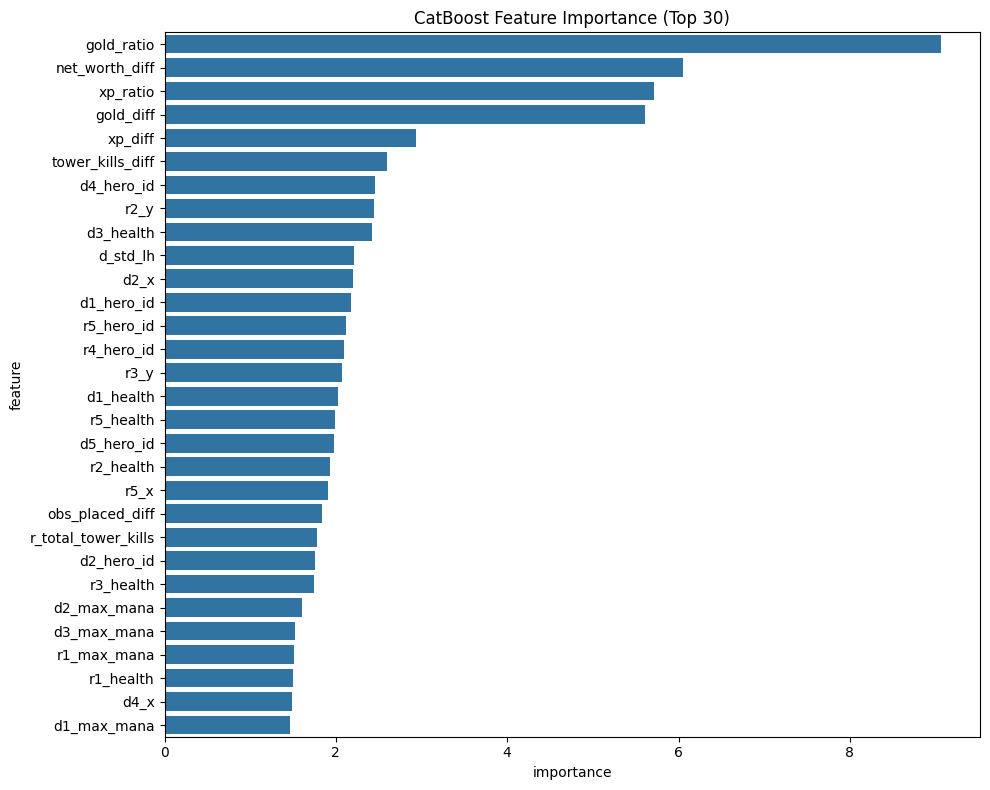

In [39]:
cat_model = CatBoostClassifier(**cat_params, random_state=69, verbose=0)
cat_model.fit(X_train, y_train)
cat_importances = cat_model.get_feature_importance()
plot_feature_importance(cat_importances, X_selected.columns, "CatBoost")

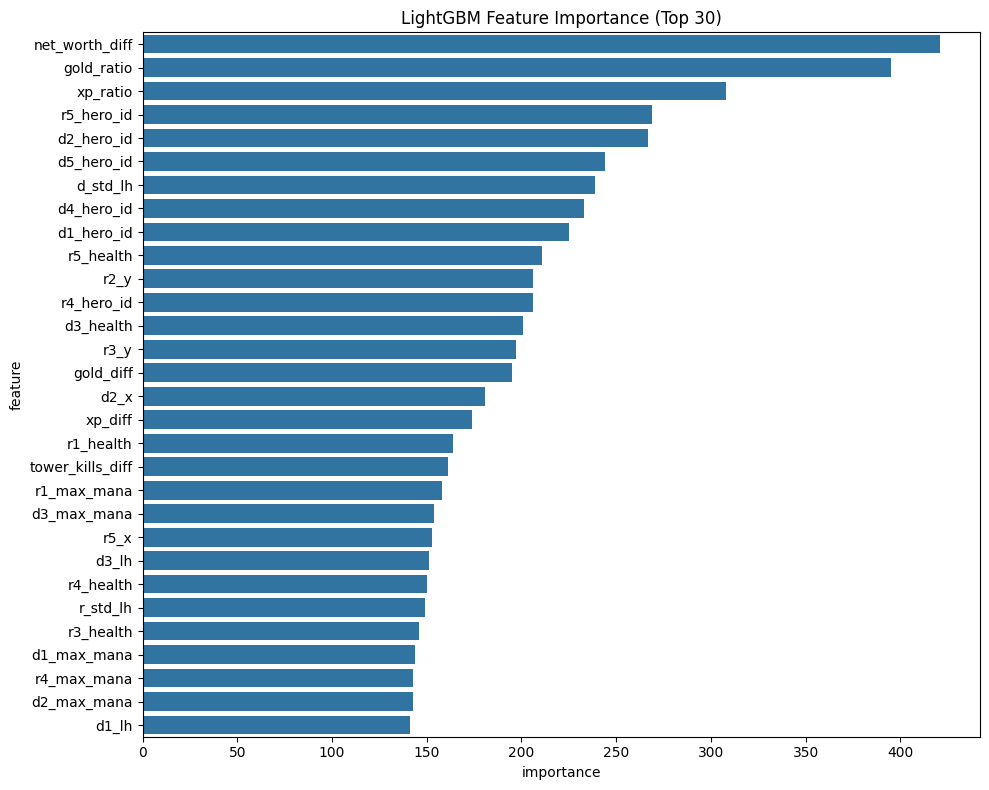

In [43]:
lgb_model = lgb.LGBMClassifier(**lgb_params, random_state=69, verbose=-1)
lgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
lgb_importances = lgb_model.feature_importances_
plot_feature_importance(lgb_importances, X_selected.columns, "LightGBM")

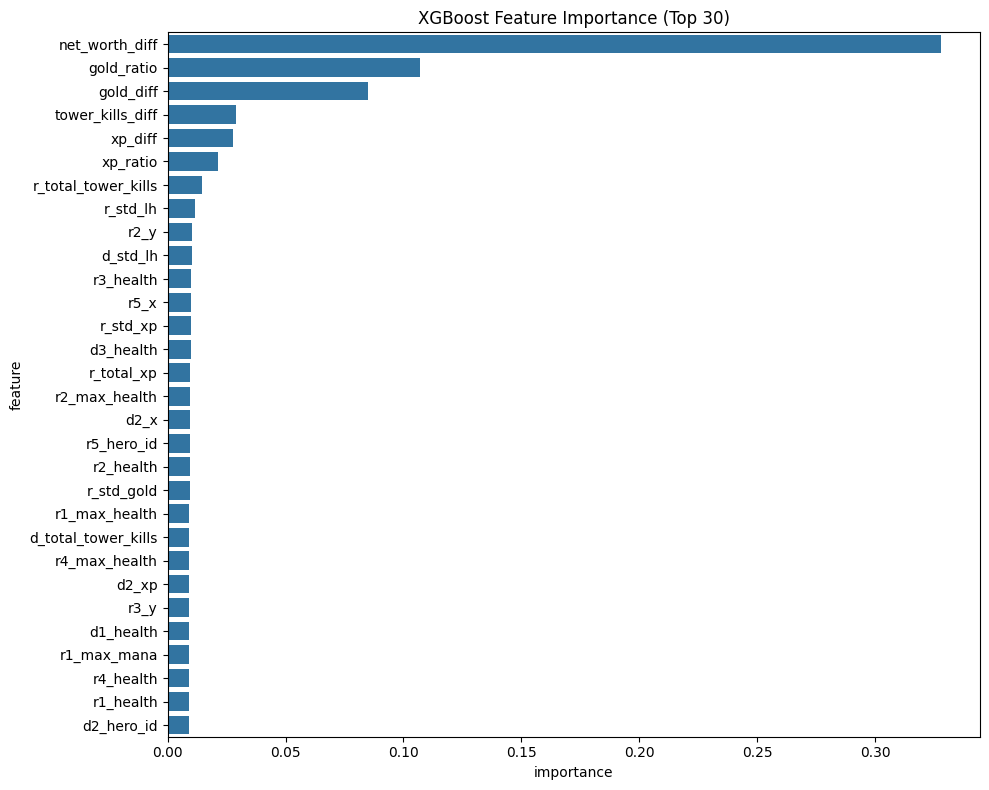

In [40]:
xgb_model = XGBClassifier(**xgb_params, random_state=69, use_label_encoder=False, eval_metric='auc')
xgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
xgb_importances = xgb_model.feature_importances_
plot_feature_importance(xgb_importances, X_selected.columns, "XGBoost")